In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def constraint(theta, joint):
    #joint please input string object
    #refer from IRB 140-ABB's setting PDF
    #joint_one is 360, joint 2 is 200, joint 3 is 280(in degree)
    #joint_one's output is -180 ~ 180
    #joint_two's output is -90 ~ 110
    #joint_three's output is -230 ~ 50
    
    if joint == 'joint_one':
        output = theta
        return output
    elif joint == 'joint_two':
        if theta < 110 and theta > -90:
            output = theta
            return output
        else:
            output = 181
            return output
    elif joint == 'joint_three':
        if theta > -230 and theta < 50:
            output = theta
            return output
        else:
            output = 181
            return output

In [3]:
def get_theta(x, y, z):
    #return three joint's theta
    #the origin of the pose is the theta1 = 0, theta2 = -90, theta3 = 90
    #ABB-140's clockwise rotation is positive in the controlling IO
    y_base = 352
    x_base = 70
    l1 = 360
    l2 = 445
    #set the parameter
    
    d = math.sqrt(x ** 2 + y ** 2)
    #the new surface's x
    r = math.sqrt((d - x_base) ** 2 + (z - y_base) ** 2)
    if r > abs(l1 - l2) and r < (l1 + l2) and z > 0:    
        theta1 = math.atan2(y, x)
        theta_one = theta1 * 180 / math.pi + math.pi / 2
        theta_one = constraint(theta_one, 'joint_one')
        #get theta 1
    
        theta3 = math.pi - math.acos((l1 ** 2 + l2 ** 2 - r ** 2) / (2 * l1 * l2))
        theta_three1 = -math.pi / 2 + theta3
        theta_three1 = theta_three1 * 180 / math.pi
        theta_three1 = constraint(theta_three1, 'joint_three')
        theta_three2 = -math.pi / 2 - theta3
        theta_three2 = theta_three2 * 180 / math.pi
        theta_three2 = constraint(theta_three2, 'joint_three')
        
        theta2 = math.acos((r ** 2 + l1 ** 2 - l2 ** 2) / (2 * r * l1))
        theta_two1 = math.atan2((z - y_base), (r - x_base)) + theta2
        theta_two1 = -theta_two1 + math.pi / 2
        theta_two1 = theta_two1 * 180 / math.pi
        theta_two1 = constraint(theta_two1, 'joint_two')
        theta_two2 = math.atan2((z - y_base), (r - x_base)) - theta2
        theta_two2 = -theta_two2 + math.pi / 2
        theta_two2 = theta_two2 * 180 / math.pi
        theta_two2 = constraint(theta_two2, 'joint_two')
        
        return theta_one, theta_two1, theta_two2, theta_three1, theta_three2        
    else:
        return 'out of work space'      

In [4]:
def path_generator(x_start, y_start, z_start, x_goal, y_goal, z_goal, x_box, y_box, z_box, leng, wid, high):
    #the point of the box means the middle points of the box
    #position array is point_num * (x, y, z)

    outer = 50
    outer_high = 20
    #set the parameter
    r = math.sqrt(leng ** 2 + wid ** 2) + outer
    r_high = math.sqrt(leng ** 2 + wid ** 2 + high ** 2) + outer_high
    
    line_vec = np.asarray([x_goal - x_start, y_goal - y_start, z_goal - z_start])
    len_vec = math.sqrt(line_vec[0] ** 2 + line_vec[1] ** 2 + line_vec[2] ** 2)
    
    t1 = (line_vec[0] * (x_box - x_start) + line_vec[1] * (y_box - y_start) + line_vec[2] * (z_box - z_start)) / len_vec ** 2
    check_high = math.sqrt((x_box - (x_start + line_vec[0] * t1)) ** 2 + (y_box - (y_start + line_vec[1] * t1)) ** 2 + (z_box - (z_start + line_vec[2] * t1)) ** 2)
    #t2 = (line_vec[0] * (x_box - x_start) + line_vec[1] * (y_box - y_start)) / (line_vec[0] ** 2 + line_vec[1] ** 2)
    #check = math.sqrt((x_box - (x_start + line_vec[0] * t2)) ** 2 + (y_box - (y_start + line_vec[1] * t2)) ** 2)
    #print(check_high)
    #print(check)
    if check_high >= r_high:
        points = np.zeros((2, 3))
        #set the position array of points of the path
        
        points[0, 0] = x_start
        points[0, 1] = y_start
        points[0, 2] = z_start
    
        points[1, 0] = x_goal
        points[1, 1] = y_goal
        points[1, 2] = z_goal
    
    else:
        points = np.zeros((6, 3))
        #set the position array of points of the path
    
        points[0, 0] = x_start
        points[0, 1] = y_start
        points[0, 2] = z_start
    
        points[5, 0] = x_goal
        points[5, 1] = y_goal
        points[5, 2] = z_goal
        
        start_angle = math.atan2((y_start - y_box),(x_start - x_box))
        points[1, 0] = x_box + r * math.cos(start_angle)
        points[1, 1] = y_box + r * math.sin(start_angle)
        points[1, 2] = z_box
        
        end_angle = math.atan2((y_goal - y_box), (x_goal - x_box))
        points[4, 0] = x_box + r * math.cos(end_angle)
        points[4, 1] = y_box + r * math.sin(end_angle)
        points[4, 2] = z_box
        
        higher_z = high / 2 + outer_high
        points[2, 0] = (points[4, 0] - points[1, 0]) / 4 + points[1, 0]
        points[2, 1] = (points[4, 1] - points[1, 1]) / 4 + points[1, 1]
        points[2, 2] = z_box + higher_z
        
        points[3, 0] = 3 * (points[4, 0] - points[1, 0]) / 4 + points[1, 0]
        points[3, 1] = 3 * (points[4, 1] - points[1, 1]) / 4 + points[1, 1]
        points[3, 2] = z_box + higher_z
        
        
    return points

In [5]:
#main path control model
def moving_path(x_start, y_start, z_start, x_goal, y_goal, z_goal):
    #if the path meet singular point, will get the joint theta information of degre
    
    speed = 1
    #set the parameter
    
    path_one_check = 0
    path_two_check = 0
    distance = math.sqrt((x_goal - x_start) ** 2 + (y_goal - y_start) ** 2 + (z_goal - z_start) ** 2)
    line_vec = np.asarray([x_goal - x_start, y_goal - y_start, z_goal - z_start]) 
    point_num = int(distance / speed)
    
    theta = np.empty(((point_num + 1), 5))
    #set the array of theta
    if get_theta(x_goal, y_goal, z_goal) == 'out of work space':
        return 'path planning fail'
    
    theta[point_num, 0], theta[point_num, 1], theta[point_num, 2], theta[point_num, 3], theta[point_num, 4] = get_theta(x_goal, y_goal, z_goal)
    
    for i in range(point_num):
        point_temp = np.asarray([x_start + i * line_vec[0] / point_num, y_start + i * line_vec[1] / point_num, z_start + i * line_vec[2] / point_num])
        if get_theta(point_temp[0], point_temp[1], point_temp[2]) == 'out of work space':
            print(point_temp)
            return 'path planning fail'
        else:
            theta[i, 0], theta[i, 1], theta[i, 2], theta[i, 3], theta[i, 4] = get_theta(point_temp[0], point_temp[1], point_temp[2])
            if theta[i, 1] == 181 or theta[i, 3] == 181:
                path_one_check += 1
            if theta[i, 2] == 181 or theta[i, 4] == 181:
                path_two_check += 1

    return theta, point_num, path_one_check, path_two_check

path one generating done, no singular point
start output path_one.txt
path_one.txt output done


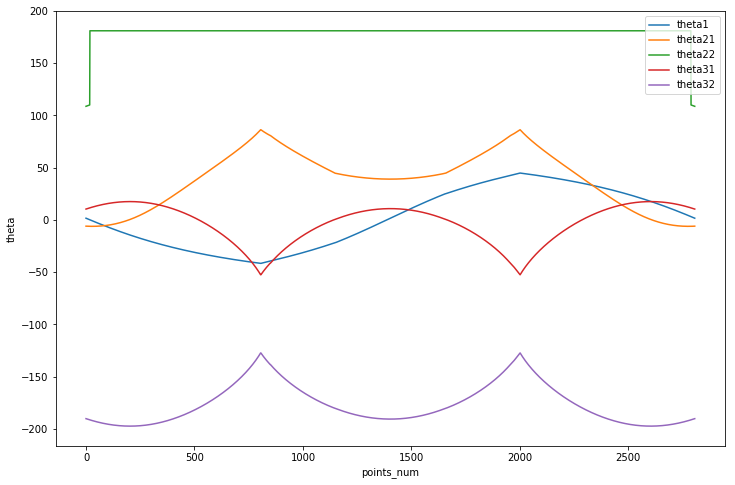

In [7]:
'''main code'''

#set the parameter
#the origin of the theta(0, 0, 0) is (445, 0 712) 
x_start = 445 + 140
y_start = -550
z_start = 140
x_goal = 445 + 140
y_goal = 550
z_goal = 140
x_box = 445 + 140
y_box = 0
z_box = 140
leng = 360
wid = 280
high = 280
###################
path_one_check = 0
path_two_check = 0
point = path_generator(x_start, y_start, z_start, x_goal, y_goal, z_goal, x_box, y_box, z_box, leng, wid, high)
#to include the start point
point = np.append(np.asarray([445, 0, 712]), point)
point = np.append(point, np.asarray([445, 0, 712]))
point = np.reshape(point, (-1, 3))

path_theta = np.asarray([])
point_num = 0
for i in range(int(point.shape[0] - 1)):
    if moving_path(point[i, 0], point[i, 1], point[i, 2], point[(i + 1), 0], point[(i + 1), 1], point[(i + 1), 2]) == 'path planning fail':
        print('error path generating, please debug')
        exit()
        
    else:
        theta_temp, point_num_temp, path_one_check_temp, path_two_check_temp = moving_path(point[i, 0], point[i, 1], point[i, 2], point[(i + 1), 0], point[(i + 1), 1], point[(i + 1), 2])
        path_theta = np.append(path_theta, theta_temp)
        path_one_check = path_one_check + path_one_check_temp
        path_two_check = path_two_check + path_two_check_temp 
        point_num = point_num + point_num_temp + 1
        
path_theta = np.reshape(path_theta, (-1, 5))

if path_one_check == 0:
    print('path one generating done, no singular point\nstart output path_one.txt')
    out_file = open('path_one.txt' , 'w')

    lines = []
    for i in range(path_theta.shape[0]):
        lines.append(str(path_theta[i, 0]) + ' ' + str(path_theta[i, 1]) + ' ' + str(path_theta[i, 3]) + ' 0 0 0\n')
    
    out_file.writelines(lines)
    out_file.close()
    
    print('path_one.txt output done')

if path_two_check == 0:
    print('path one generating done, no singular point\nstart output path_two.txt')    
    out_file = open('path_two.txt' , 'w')

    lines = []
    for i in range(path_theta.shape[0]):
        lines.append(str(path_theta[i, 0]) + ',' + str(path_theta[i, 2]) + ',' + str(path_theta[i, 4]) + ' 0 0 0\n')
    
    out_file.writelines(lines)
    out_file.close()
    
    print('path_two.txt output done')

if path_one_check != 0 and path_two_check != 0:
    print('Two path constrain fail, please try another method')

x = np.arange(point_num)

plt.figure(figsize=(12, 8))
plt.plot(x, path_theta[:, 0], label= 'theta1')
plt.plot(x, path_theta[:, 1], label= 'theta21')
plt.plot(x, path_theta[:, 2], label= 'theta22')
plt.plot(x, path_theta[:, 3], label= 'theta31')
plt.plot(x, path_theta[:, 4], label= 'theta32')
plt.xlabel('points_num')
plt.ylabel('theta')
plt.legend()
plt.show()
